In [1]:
import numpy as np
import math

In [2]:
def ricker(freq, length, dt, peak_time):
    """Return a Ricker wavelet with the specified central frequency.
    Args:
        freq: A float specifying the central frequency
        length: An int specifying the number of time samples
        dt: A float specifying the time sample spacing
        peak_time: A float specifying the time (in secs) of the peak amplitude
        dtype: The PyTorch datatype to use. Optional, defaults to default.
    """
    t = np.arange(0,length)*dt - peak_time
    y = (1-2*math.pi**2 * freq**2 * t**2) * np.exp(-math.pi**2 * freq**2 * t**2)
    return y

In [3]:
dt = 0.001                     # delta
timeLen = 1                    # in second
nt = int(timeLen/dt)           # sample points
peak_freq = 10                  # in Hz
q0 = 1
peak_sorce_time = 1/peak_freq  #
source_amplitudes = q0 * ricker(peak_freq, nt, dt, peak_sorce_time)
src = source_amplitudes

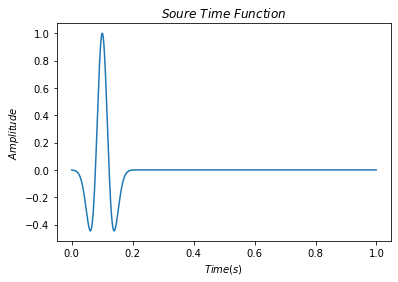

In [4]:
# plot source time function
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(np.arange(0,nt)*dt,source_amplitudes)
plt.xlabel('$Time(s)$')
plt.ylabel('$Amplitude$')
plt.title('$Soure\ Time\ Function$')
#plt.grid(ls='--')
plt.show()

198


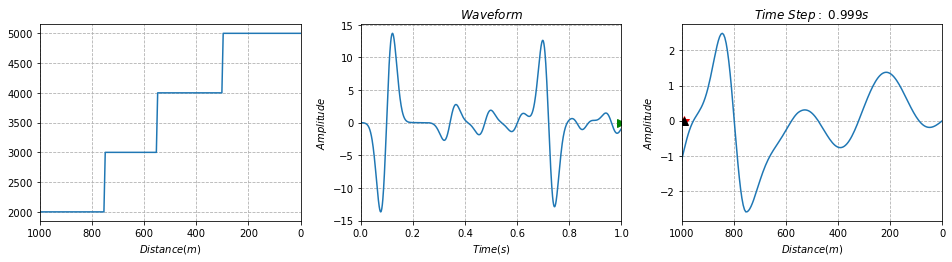

In [6]:
# 1D Wave Propagation (Finite Difference Solution)

nx   = 200         # number of grid points in x-direction
dx   = 5          # grid point distance in x-direction
c0   = 333.         # wave speed in medium (m/s)
isrc = 198          # source location in grid in x-direction
ir   = 198          # receiver location in grid in x-direction

# Initialize empty pressure
# -------------------------
p    = np.zeros(nx) # p at time n (now)
pold = np.zeros(nx) # p at time n-1 (past)
pnew = np.zeros(nx) # p at time n+1 (present)
d2px = np.zeros(nx) # 2nd space derivative of p
dc1px = np.zeros(nx)
p1px = np.zeros(nx)

# Initialize empty seismogram
seis = np.zeros(nt)

# Initialize model (assume homogeneous model)
# -------------------------------------------
c    = np.concatenate((np.ones(60)*5000, np.ones(50)*4000, np.ones(40)*3000, np.ones(50)*2000))
#c    = np.concatenate((np.ones(60)*5000, np.linspace(5000,2000,90), np.ones(50)*2000))
#c = np.linspace(500, 400, nx)
vel = c
#c = sm_vel_value
#c = new_sm_vel
def plot_p(it, nt, dt, c0, seis, src, ir, nx, dx, ax, plottype='position'):
    if plottype == 'position':
        #ax.plot([0, nx*dx], [350, 350], ls='-')
        #ax.plot(src*dx, 350, 'r*', markersize=11)
        #ax.plot(ir*dx, 350, 'k^', markersize=8)
        #ax.plot(src*dx-np.arange(0,nt)[it]*dt*c0, 350, 'g>', markersize=8)
        pass
        
    if plottype == 'waveform':
        time = np.linspace(0 * dt, nt * dt, nt)
        ax.plot(time, seis)
        ax.plot(np.arange(0,nt)[it]*dt, 0, 'g>', markersize=8)
    
bc = 'o'
sn = -1
for it in range(nt):
    for i in range(0+1, nx-1):
        d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2
        #dc1px[i] = 2 * c[i] * (c[i +1] - c[i]) / dx
        #p1px[i] = (p[i+1] - p[i]) / dx
    
    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + c ** 2 * dt ** 2 * d2px # + dc1px * p1px * dt **2
    
    # Add Source Term at isrc
    #pnew[isrc] = pnew[isrc] + 2 * c[isrc] * src[it] / (dx) * dt ** 2
    
    pnew[isrc] = pnew[isrc] + src[it] / (dx) * dt ** 2 * c[isrc]**2
    # test
    # c_c = c**2 * dt**2
    # c_c[isrc] = c_c[isrc] * src[it] / (dx)
    # pnew = pnew + c_c
    
    if it == range(nt)[sn]:
        print(isrc)
        #print(pnew)
    
    if bc == 'd': # Dirichlet
        pnew[0] = 0
        pnew[-1] = 0
    if bc == 'o': # open
        pnew[-1] = pnew[-2] - 1/c[-1] * (pnew[-2] - p[-2])*dx/dt
        #pnew[-1] = pnew[-2]
        pnew[0] = 0
    # Remap Time Levels
    pold, p = p, pnew
    
    seis[it] = p[ir]
    
    if it == range(nt)[sn]:
        plt.figure(figsize=(16/1.2,4.5/1.2))
        ax1 = plt.subplot(131)
        plot_p(it, nt, dt, c0, seis, isrc, ir, nx, dx, ax1, plottype='position')
        ax1.plot(np.linspace(0 * dx, nx * dx, nx),c)
        ax1.set_xlim([0, nx*dx])
        ax1.invert_xaxis()
        ax1.set_xlabel('$Distance(m)$')
        ax1.grid(ls='--')
        
        ax2 = plt.subplot(132)
        plot_p(it, nt, dt, c0, seis, isrc, ir, nx, dx, ax2, plottype='waveform')
        ax2.set_xlim([0, nt*dt])
        ax2.set_xlabel('$Time(s)$')
        ax2.set_ylabel('$Amplitude$')
        ax2.set_title('$Waveform$')
        ax2.grid(ls='--')
        
        ax3 = plt.subplot(133)
        time = np.linspace(0 * dt, nt * dt, nt)
        ax3.plot(np.linspace(0 * dx, nx * dx, nx), pold)
        ax3.plot(isrc*dx, 0, 'r*', markersize=11)
        ax3.plot(ir*dx, 0, 'k^', markersize=8)
        ax3.set_xlim([0, nx*dx])
        ax3.set_xlabel('$Distance(m)$')
        ax3.set_ylabel('$Amplitude$')
        ax3.set_title(f'$Time\ Step:\ {it*dt}s$')
        ax3.invert_xaxis()
        ax3.grid(ls='--')
        #print(src[it] / (dx) * dt ** 2)
        
        plt.tight_layout()
        plt.show()

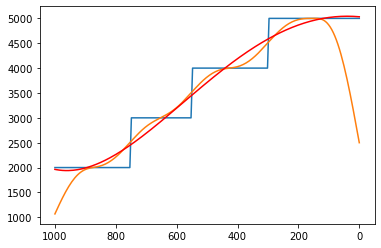

In [58]:
N = 60
weights = np.hanning(N)

smooth_vel = np.convolve(weights/weights.sum(), vel, 'same')
sm_vel_poly = np.polyfit(np.linspace(0 * dx, nx * dx, nx), vel, 4)
sm_vel_value = np.polyval(sm_vel_poly, np.linspace(0 * dx, nx * dx, nx))

plt.figure()
ax_vel_true = plt.subplot(111)
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), vel)
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), smooth_vel)
ax_vel_true.plot(np.linspace(0 * dx, nx * dx, nx), sm_vel_value, '')
ax_vel_true.invert_xaxis()

In [60]:
sm_vel_value[sm_vel_value<2000] = sm_vel_value[sm_vel_value<2000]*0+2000
print(sm_vel_value<2000)
sm_vel_value[sm_vel_value>5000] = sm_vel_value[sm_vel_value>5000]*0+5000
new_sm_vel = sm_vel_value

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [54]:
np.concatenate((np.ones(60)*5000, np.ones(50)*4000, np.ones(50)*4000))

array([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
       5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
       5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
       5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
       5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
       5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
       5000., 5000., 5000., 5000., 5000., 5000., 4000., 4000., 4000.,
       4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000., 4000.,
       4000., 4000.,

In [23]:
help(plt.figure())

Help on Figure in module matplotlib.figure object:

class Figure(matplotlib.artist.Artist)
 |  Figure(figsize=None, dpi=None, facecolor=None, edgecolor=None, linewidth=0.0, frameon=None, subplotpars=None, tight_layout=None, constrained_layout=None)
 |  
 |  The top level container for all the plot elements.
 |  
 |  The Figure instance supports callbacks through a *callbacks* attribute
 |  which is a `.CallbackRegistry` instance.  The events you can connect to
 |  are 'dpi_changed', and the callback will be called with ``func(fig)`` where
 |  fig is the `Figure` instance.
 |  
 |  Attributes
 |  ----------
 |  patch
 |      The `.Rectangle` instance representing the figure background patch.
 |  
 |  suppressComposite
 |      For multiple figure images, the figure will make composite images
 |      depending on the renderer option_image_nocomposite function.  If
 |      *suppressComposite* is a boolean, this will override the renderer.
 |  
 |  Method resolution order:
 |      Figure
 |

<Figure size 432x288 with 0 Axes>